# Load Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Step 1.1 Load the Data

In [2]:
import os
print(os.getcwd())

# Specify the correct file path
file_path = 'C:/Users/Xande/OneDrive/Documents/Masters Project/Simulated Data/data/categorical_label_simulated_data.csv'   
file_path_2 = 'C:/Users/Xande/OneDrive/Documents/Masters Project/Simulated Data/data/categorica_labels.csv'   

# Load the dataset
data = pd.read_csv(file_path)
labels = pd.read_csv(file_path_2)

# Drop the first column  (only applicable for the left-shifted data frame, not needed for the complete cases)
#data = data.iloc[:, 1:]

# Display the first few rows of the data
data.head()
labels.head()

c:\Users\Xande\OneDrive\Documents\Masters Project\Simulated Data\data\Jupyter Notebooks


,id,Label
0,2147483759,1
1,2147532784,0
2,2147545003,0
3,2147576120,0
4,2147613750,0


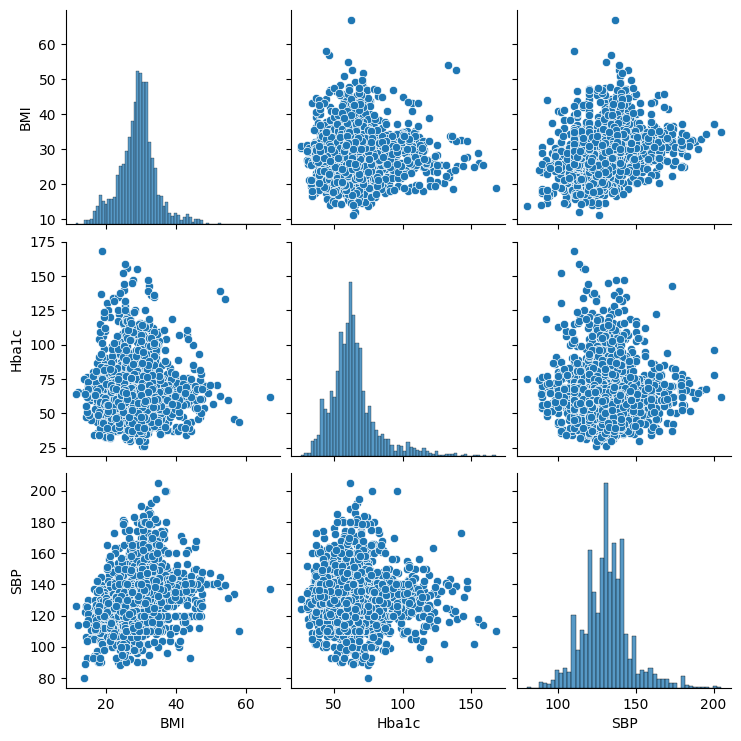

In [3]:
# Scatter matrix for initial data exploration
sns.pairplot(data[['BMI', 'Hba1c', 'SBP']])
plt.show()

## Data Pre-Processing

In [4]:
# Normalize the features
scaler = StandardScaler()
data[['BMI', 'Hba1c', 'SBP']] = scaler.fit_transform(data[['BMI', 'Hba1c', 'SBP']])

# Prepare the sequences for each individual
def create_sequences(data):
    sequences = []
    ids = data['id'].unique()
    for id_ in ids:
        person_data = data[data['id'] == id_].drop(columns=['id']).values
        sequences.append(person_data)
    return sequences

sequences = create_sequences(data)

# Pad the sequences to have the same length
padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')

# Convert labels to a dictionary for easy lookup
label_dict = dict(zip(labels['id'], labels['Label']))

# Prepare labels for sequences
sequence_labels = [label_dict[id_] for id_ in data['id'].unique()]

## Split the Data into Train and Test and Build the GRU Model

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, sequence_labels, test_size=0.2, random_state=42)

# Function to build the GRU model with hyperparameters
def build_gru_model(input_shape, learning_rate=0.001, dropout_rate=0.0, gru_units=32, use_dropout=False):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))
    model.add(GRU(gru_units, return_sequences=False))
    if use_dropout:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set hyperparameters
learning_rate = 0.001
dropout_rate = 0.2
gru_units = 32
use_dropout = True

# Build the model
model = build_gru_model(input_shape=(padded_sequences.shape[1], padded_sequences.shape[2]), 
                        learning_rate=learning_rate, 
                        dropout_rate=dropout_rate, 
                        gru_units=gru_units, 
                        use_dropout=use_dropout)

c:\Users\Xande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Model Training and Evaluation

In [14]:
# Train the model
history = model.fit(X_train, np.array(y_train), epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5887 - loss: 0.6903 - val_accuracy: 0.7463 - val_loss: 0.6688
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5865 - loss: 0.6770 - val_accuracy: 0.6866 - val_loss: 0.6602
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6344 - loss: 0.6696 - val_accuracy: 0.7164 - val_loss: 0.6523
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6988 - loss: 0.6524 - val_accuracy: 0.7164 - val_loss: 0.6443
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6584 - loss: 0.6517 - val_accuracy: 0.7015 - val_loss: 0.6373
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6796 - loss: 0.6342 - val_accuracy: 0.7015 - val_loss: 0.6301
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6924 - loss: 0.6251 - val_accuracy: 0.7313 - val_loss: 0.6220
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7355 - loss: 0.6103 - val_accuracy: 0.7313 - val_loss: 0.6125


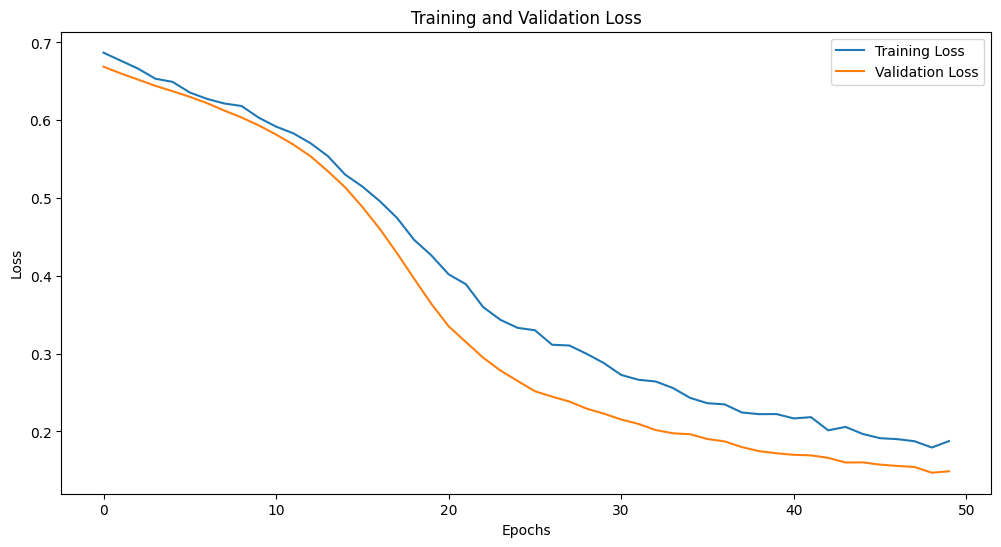

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000244E156D9E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Confusion Matrix:
[[43  2]
 [ 4 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.95   

In [15]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


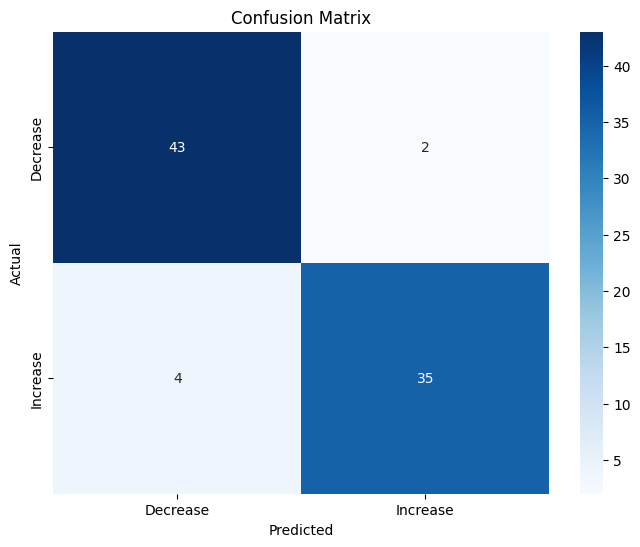

Classification Report:
              precision    recall  f1-score   support

    Decrease       0.91      0.96      0.93        45
    Increase       0.95      0.90      0.92        39

    accuracy                           0.93        84
   macro avg       0.93      0.93      0.93        84
weighted avg       0.93      0.93      0.93        84



In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test and y_pred are defined as in your previous steps
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(y_test, y_pred, target_names=['Decrease', 'Increase'])
print("Classification Report:")
print(class_report)